Here I'll try to visualize the VCF files better to determine the optimal filter criteria.

TODO 3/26: Re-running pipeline from merge onwards but taking average of DP instead of sum... check DP plots further down

In [2]:
import pandas as pd

# Import VCF file w/ proper column names
variants = pd.read_csv('out/variants.vcf.gz', compression='gzip', comment='#', sep='\t', header=None,
    names = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT'] + [i for i in range(1,62)])
variants.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,1,...,52,53,54,55,56,57,58,59,60,61
0,Lu1,10,.,G,A,33.41630,.,VDB=0.06;SGB=-0.453602;RPBZ=-1.22474;MQBZ=1.22...,GT:PL,./.:.,...,"1/1:39,9,0",./.:.,"1/1:40,9,0",./.:.,./.:.,"0/1:37,0,52",./.:.,"1/1:54,8,0",./.:.,./.:.
1,Lu1,12,.,T,A,5.68822,.,SGB=-0.379885;RPBZ=-1;MQBZ=1;MQSBZ=-1;BQBZ=-1;...,GT:PL,./.:.,...,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.
2,Lu1,15,.,G,A,54.41460,.,VDB=0.06;SGB=-0.453602;MQSBZ=-1;MQ0F=0.5;MQ=20...,GT:PL,./.:.,...,"1/1:39,9,0",./.:.,"1/1:44,9,0",./.:.,"1/1:53,12,0","0/1:40,0,45","1/1:35,6,0","1/1:72,15,0",./.:.,"1/1:41,6,0"
3,Lu1,19,.,T,A,4.97970,.,SGB=-0.379885;RPBZ=-1;MQBZ=1;MQSBZ=-1;BQBZ=1;S...,GT:PL,./.:.,...,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.,./.:.
4,Lu1,33,.,G,T,34.41590,.,VDB=0.160332;SGB=-0.511536;MQ0F=0;MQ=21;RPBZ=-...,GT:PL,./.:.,...,"1/1:42,12,0","1/1:57,9,0","1/1:43,9,0",./.:.,./.:.,"0/1:40,0,45","1/1:50,3,0","0/1:56,0,22",./.:.,./.:.


First, I'll extract the values that are of interest and then compute some additional useful columns.

In [4]:
useful_variants = variants[['QUAL', 'REF', 'ALT', 'INFO']].copy()
# Filter for SNPs only, no INDELs
snps_filter = (useful_variants['REF'].str.len() == 1) & (useful_variants['ALT'].str.len() == 1)
useful_variants = useful_variants[snps_filter]
# Add DP column
useful_variants['DP'] = useful_variants['INFO'].str.extract(r'DP=(\d+)').astype(int)
# Add type of SNP
useful_variants['TYPE'] = useful_variants.apply(lambda row: '%s>%s' % (row['REF'], row['ALT']), axis=1)

useful_variants.head()

,QUAL,REF,ALT,INFO,DP,TYPE
0,33.41630,G,A,VDB=0.06;SGB=-0.453602;RPBZ=-1.22474;MQBZ=1.22...,31,G>A
1,5.68822,T,A,SGB=-0.379885;RPBZ=-1;MQBZ=1;MQSBZ=-1;BQBZ=-1;...,2,T>A
2,54.41460,G,A,VDB=0.06;SGB=-0.453602;MQSBZ=-1;MQ0F=0.5;MQ=20...,98,G>A
3,4.97970,T,A,SGB=-0.379885;RPBZ=-1;MQBZ=1;MQSBZ=-1;BQBZ=1;S...,2,T>A
4,34.41590,G,T,VDB=0.160332;SGB=-0.511536;MQ0F=0;MQ=21;RPBZ=-...,76,G>T


<Axes: xlabel='DP', ylabel='Count'>

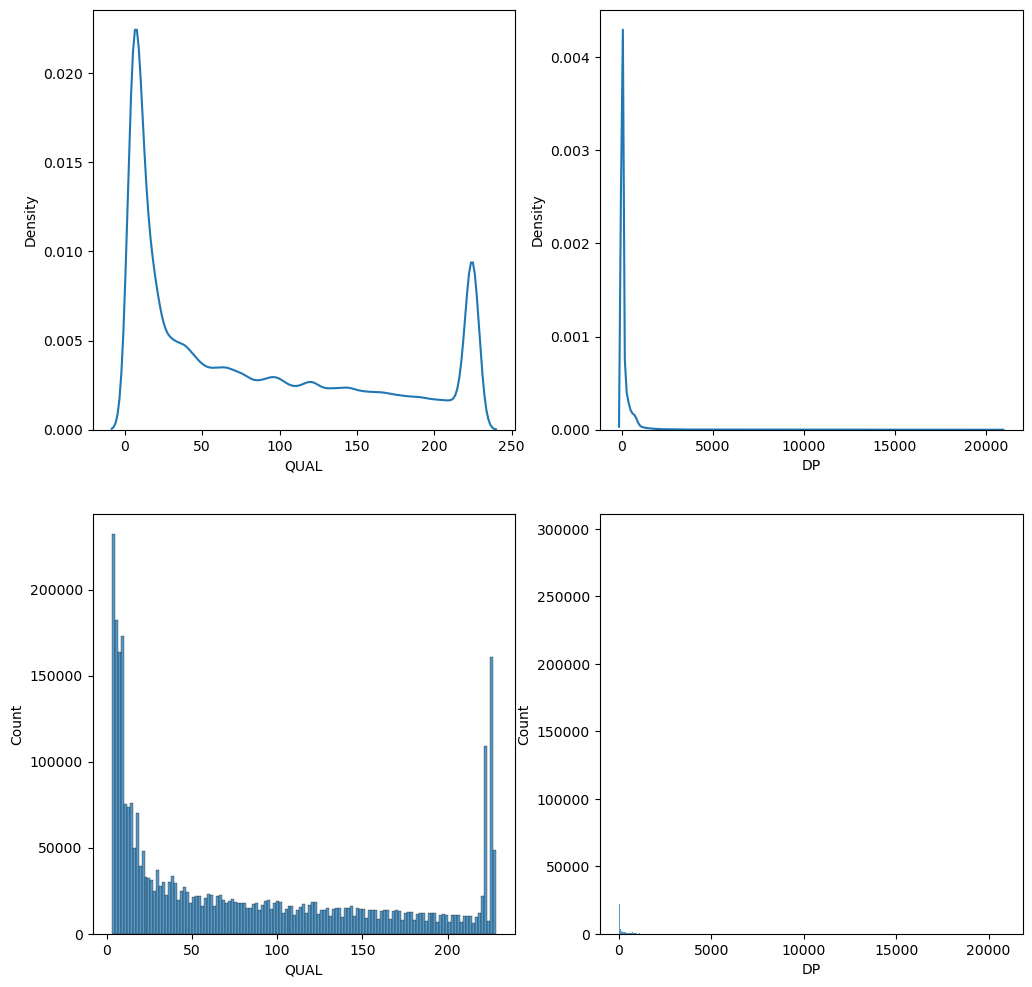

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(2,2)
f.set_figwidth(12)
f.set_figheight(12)
sns.kdeplot(useful_variants, x='QUAL', ax=ax[0,0])
sns.kdeplot(useful_variants, x='DP', ax=ax[0,1])
sns.histplot(useful_variants, x='QUAL', ax=ax[1,0])
sns.histplot(useful_variants, x='DP', ax=ax[1,1])

In [6]:
from ipywidgets import interact

@interact(qual=(0,useful_variants['QUAL'].max()))
def plot_types(qual):
    df = useful_variants[useful_variants['QUAL'] > qual]
    sns.countplot(df, x='TYPE').set_title('QUAL>%d' % qual)

interactive(children=(FloatSlider(value=114.2175, description='qual', max=228.435), Output()), _dom_classes=('…